In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import bias_correction

In [2]:
mildura_lat = -34.2
mildura_lon = 142.1

### Observations

In [3]:
#txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'

In [4]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [5]:
da_obs = ds_obs['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [6]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [7]:
df_obs = da_obs.to_dataframe()

In [8]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1990-06-30 00:00:00 -34.0  142.0  1990-01-03  48.070168
1939-06-30 00:00:00 -34.0  142.0  1939-01-10  47.354195
2001-06-30 00:00:00 -34.0  142.0  2001-01-14  47.192989
2020-06-30 00:00:00 -34.0  142.0  2019-12-20  46.924156
2019-06-30 00:00:00 -34.0  142.0  2019-01-04  46.915867
1979-06-30 00:00:00 -34.0  142.0  1979-01-14  46.859818
2017-06-30 00:00:00 -34.0  142.0  2017-02-10  46.850529
2009-06-30 00:00:00 -34.0  142.0  2009-02-07  46.835129
1932-06-30 00:00:00 -34.0  142.0  1932-01-27  46.403103
1982-06-30 00:00:00 -34.0  142.0  1982-01-24  46.376907


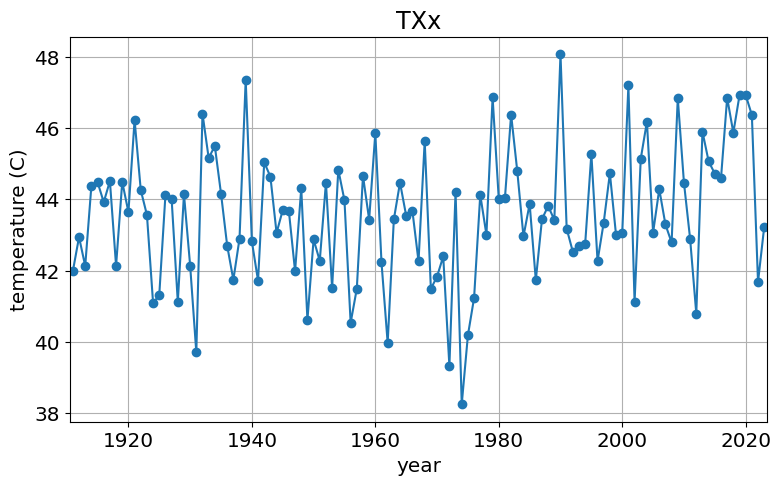

In [9]:
fig, ax = plt.subplots(figsize=[9, 5])
values = da_obs.values
years = da_obs['time'].dt.year.values
plt.plot(years, values, marker='o')
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.grid()

In [10]:
gev_shape_obs, gev_loc_obs, gev_scale_obs = eva.fit_gev(da_obs.values)
print(f'Shape parameter: {gev_shape_obs:.2f}')
print(f'Location parameter: {gev_loc_obs:.2f}')
print(f'Scale parameter: {gev_scale_obs:.2f}')

Shape parameter: 0.30
Location parameter: 42.93
Scale parameter: 1.89


### Model data

In [11]:
#txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'

In [12]:
ds_model = fileio.open_dataset(txx_model_file)

In [13]:
da_model = ds_model['tasmax'].sel({'lat': -34.2, 'lon': 142.1}, method='nearest')

In [14]:
da_model = da_model.compute()

In [15]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [16]:
gev_shape_model, gev_loc_model, gev_scale_model = eva.fit_gev(da_model_stacked.values)
print(f'Shape parameter: {gev_shape_model:.2f}')
print(f'Location parameter: {gev_loc_model:.2f}')
print(f'Scale parameter: {gev_scale_model:.2f}')

Shape parameter: 0.25
Location parameter: 45.05
Scale parameter: 2.27


### Bias correction

#### Additive - mean correction

In [17]:
bias_mean_add = bias_correction.get_bias(
    da_model,
    da_obs,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [18]:
da_model_bc_mean_add = bias_correction.remove_bias(da_model, bias_mean_add, 'additive')

In [19]:
da_model_bc_mean_add = da_model_bc_mean_add.compute()

In [20]:
da_model_bc_mean_add_stacked = da_model_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
gev_shape_model_bc_mean_add, gev_loc_model_bc_mean_add, gev_scale_model_bc_mean_add = eva.fit_gev(da_model_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_add:.2f}')

Shape parameter: 0.25
Location parameter: 42.97
Scale parameter: 2.27


#### Multiplicative - mean correction

In [22]:
bias_mean_mulc = bias_correction.get_bias(
    da_model,
    da_obs,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [23]:
da_model_bc_mean_mulc = bias_correction.remove_bias(da_model, bias_mean_mulc, 'additive')
da_model_bc_mean_mulc = da_model_bc_mean_mulc.compute()

In [24]:
da_model_bc_mean_mulc_stacked = da_model_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
gev_shape_model_bc_mean_mulc, gev_loc_model_bc_mean_mulc, gev_scale_model_bc_mean_mulc = eva.fit_gev(da_model_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 44.00
Scale parameter: 2.27


## Comparison

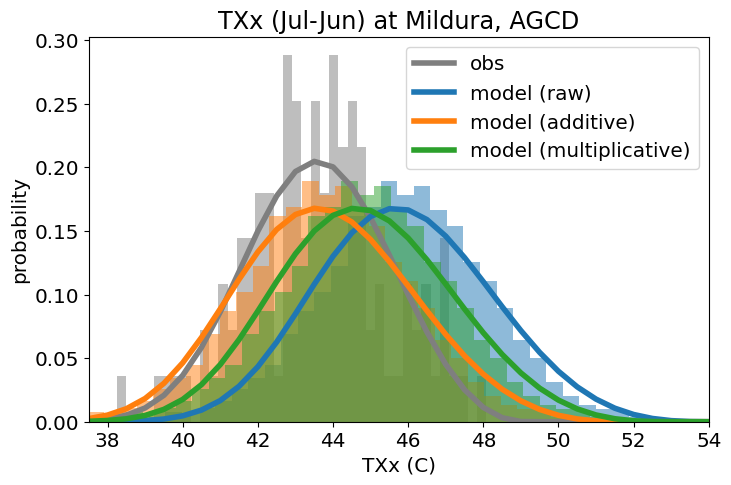

In [29]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(30, 65, 0.5)

da_obs.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5)
gev_pdf_obs = gev.pdf(gev_xvals, gev_shape_obs, gev_loc_obs, gev_scale_obs)
plt.plot(gev_xvals, gev_pdf_obs, color='tab:gray', linewidth=4.0, label='obs')

da_model_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model = gev.pdf(gev_xvals, gev_shape_model, gev_loc_model, gev_scale_model)
plt.plot(gev_xvals, gev_pdf_model, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_bc_mean_add = gev.pdf(gev_xvals, gev_shape_model_bc_mean_add, gev_loc_model_bc_mean_add, gev_scale_model_bc_mean_add)
plt.plot(gev_xvals, gev_pdf_model_bc_mean_add, color='tab:orange', linewidth=4.0, label='model (additive)')

da_model_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_bc_mean_mulc = gev.pdf(gev_xvals, gev_shape_model_bc_mean_mulc, gev_loc_model_bc_mean_mulc, gev_scale_model_bc_mean_mulc)
plt.plot(gev_xvals, gev_pdf_model_bc_mean_mulc, color='tab:green', linewidth=4.0, label='model (multiplicative)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at Mildura, AGCD')
plt.xlim(37.5, 54)
plt.legend()
plt.show()

### Raw data

In [26]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.4875908
KS p-value: 4.6272845e-25
AD score: 81.58321
AD p-value: 0.001


### Additive - mean correction

In [27]:
similarity_ds_bc_mean_add = similarity.similarity_tests(da_model_bc_mean_add, da_obs)
print('KS score:', similarity_ds_bc_mean_add['ks_statistic'].values)
print('KS p-value:', similarity_ds_bc_mean_add['ks_pval'].values)
print('AD score:', similarity_ds_bc_mean_add['ad_statistic'].values)
print('AD p-value:', similarity_ds_bc_mean_add['ad_pval'].values)

KS score: 0.116772756
KS p-value: 0.08692746
AD score: 0.79016525
AD p-value: 0.15519488


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.481808280944826 to 46.27445001602173
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.8997863978147507 to 2.544756907224655
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.691504518687725 to 0.370616329461336
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.6012833774089813 to 1.834943425655365
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17163837240677984 to 0.4357777396574594
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      floa

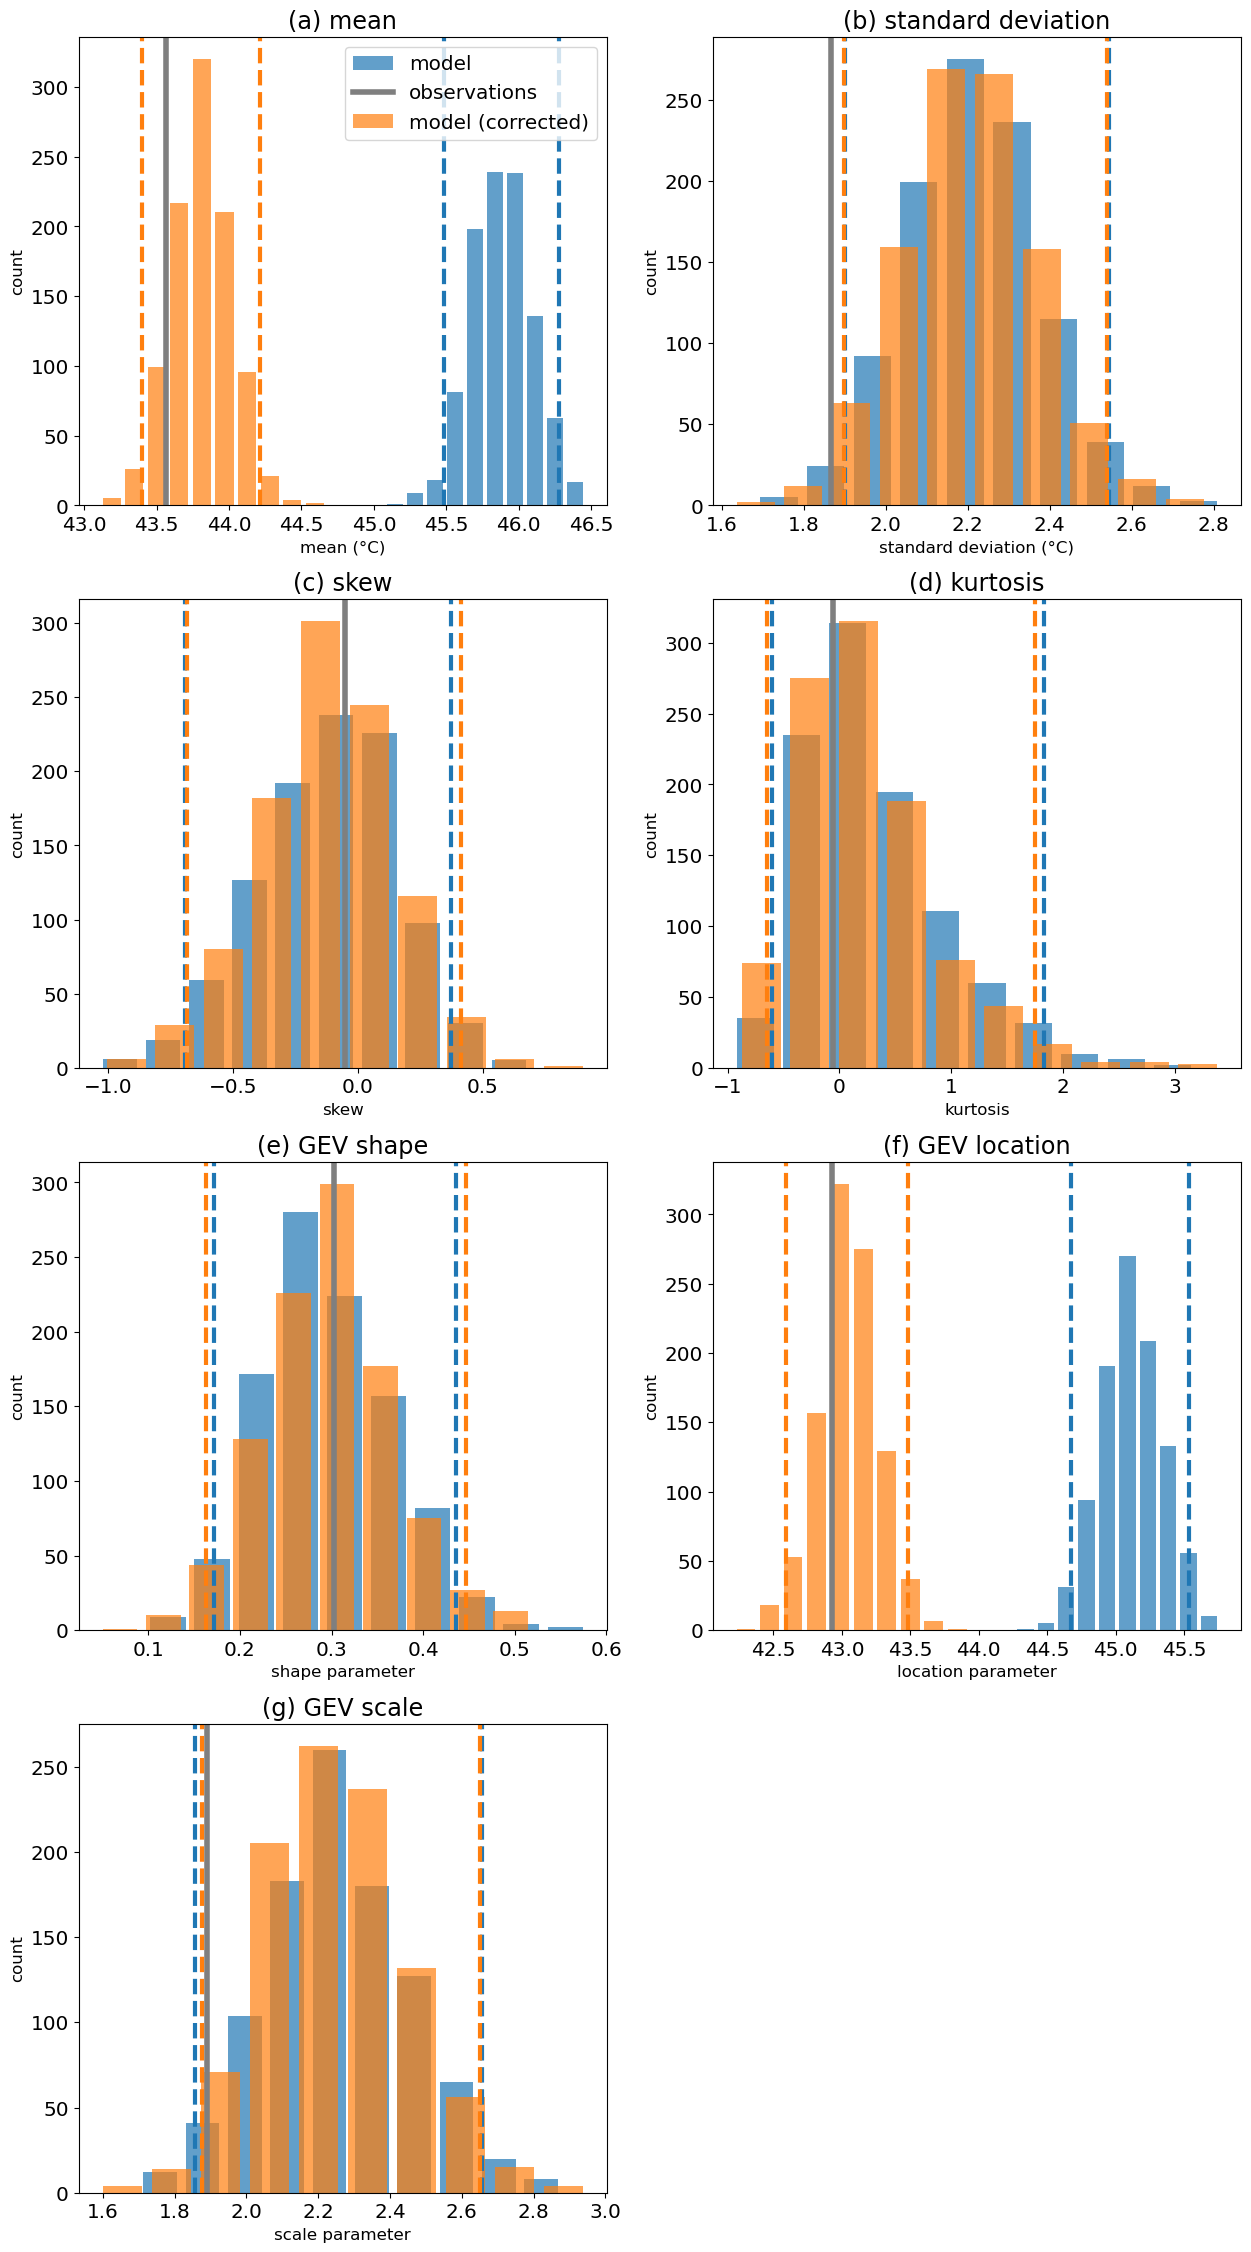

In [30]:
moments.create_plot(
    da_model,
    da_obs,
    da_bc_fcst=da_model_bc_mean_add,
)

### Multiplicative - mean correction

In [28]:
similarity_ds_bc_mean_mulc = similarity.similarity_tests(da_model_bc_mean_mulc, da_obs)
print('KS score:', similarity_ds_bc_mean_mulc['ks_statistic'].values)
print('KS p-value:', similarity_ds_bc_mean_mulc['ks_pval'].values)
print('AD score:', similarity_ds_bc_mean_mulc['ad_statistic'].values)
print('AD p-value:', similarity_ds_bc_mean_mulc['ad_pval'].values)

KS score: 0.30221066
KS p-value: 1.4292246e-09
AD score: 25.51588
AD p-value: 0.001


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.49124059677124 to 46.32151651382446
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.9326697260141372 to 2.5290428578853605
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.678446589410305 to 0.3813011765480041
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5815164387226105 to 1.7366422653198235
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.1723514281117189 to 0.4400572009165733
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      flo

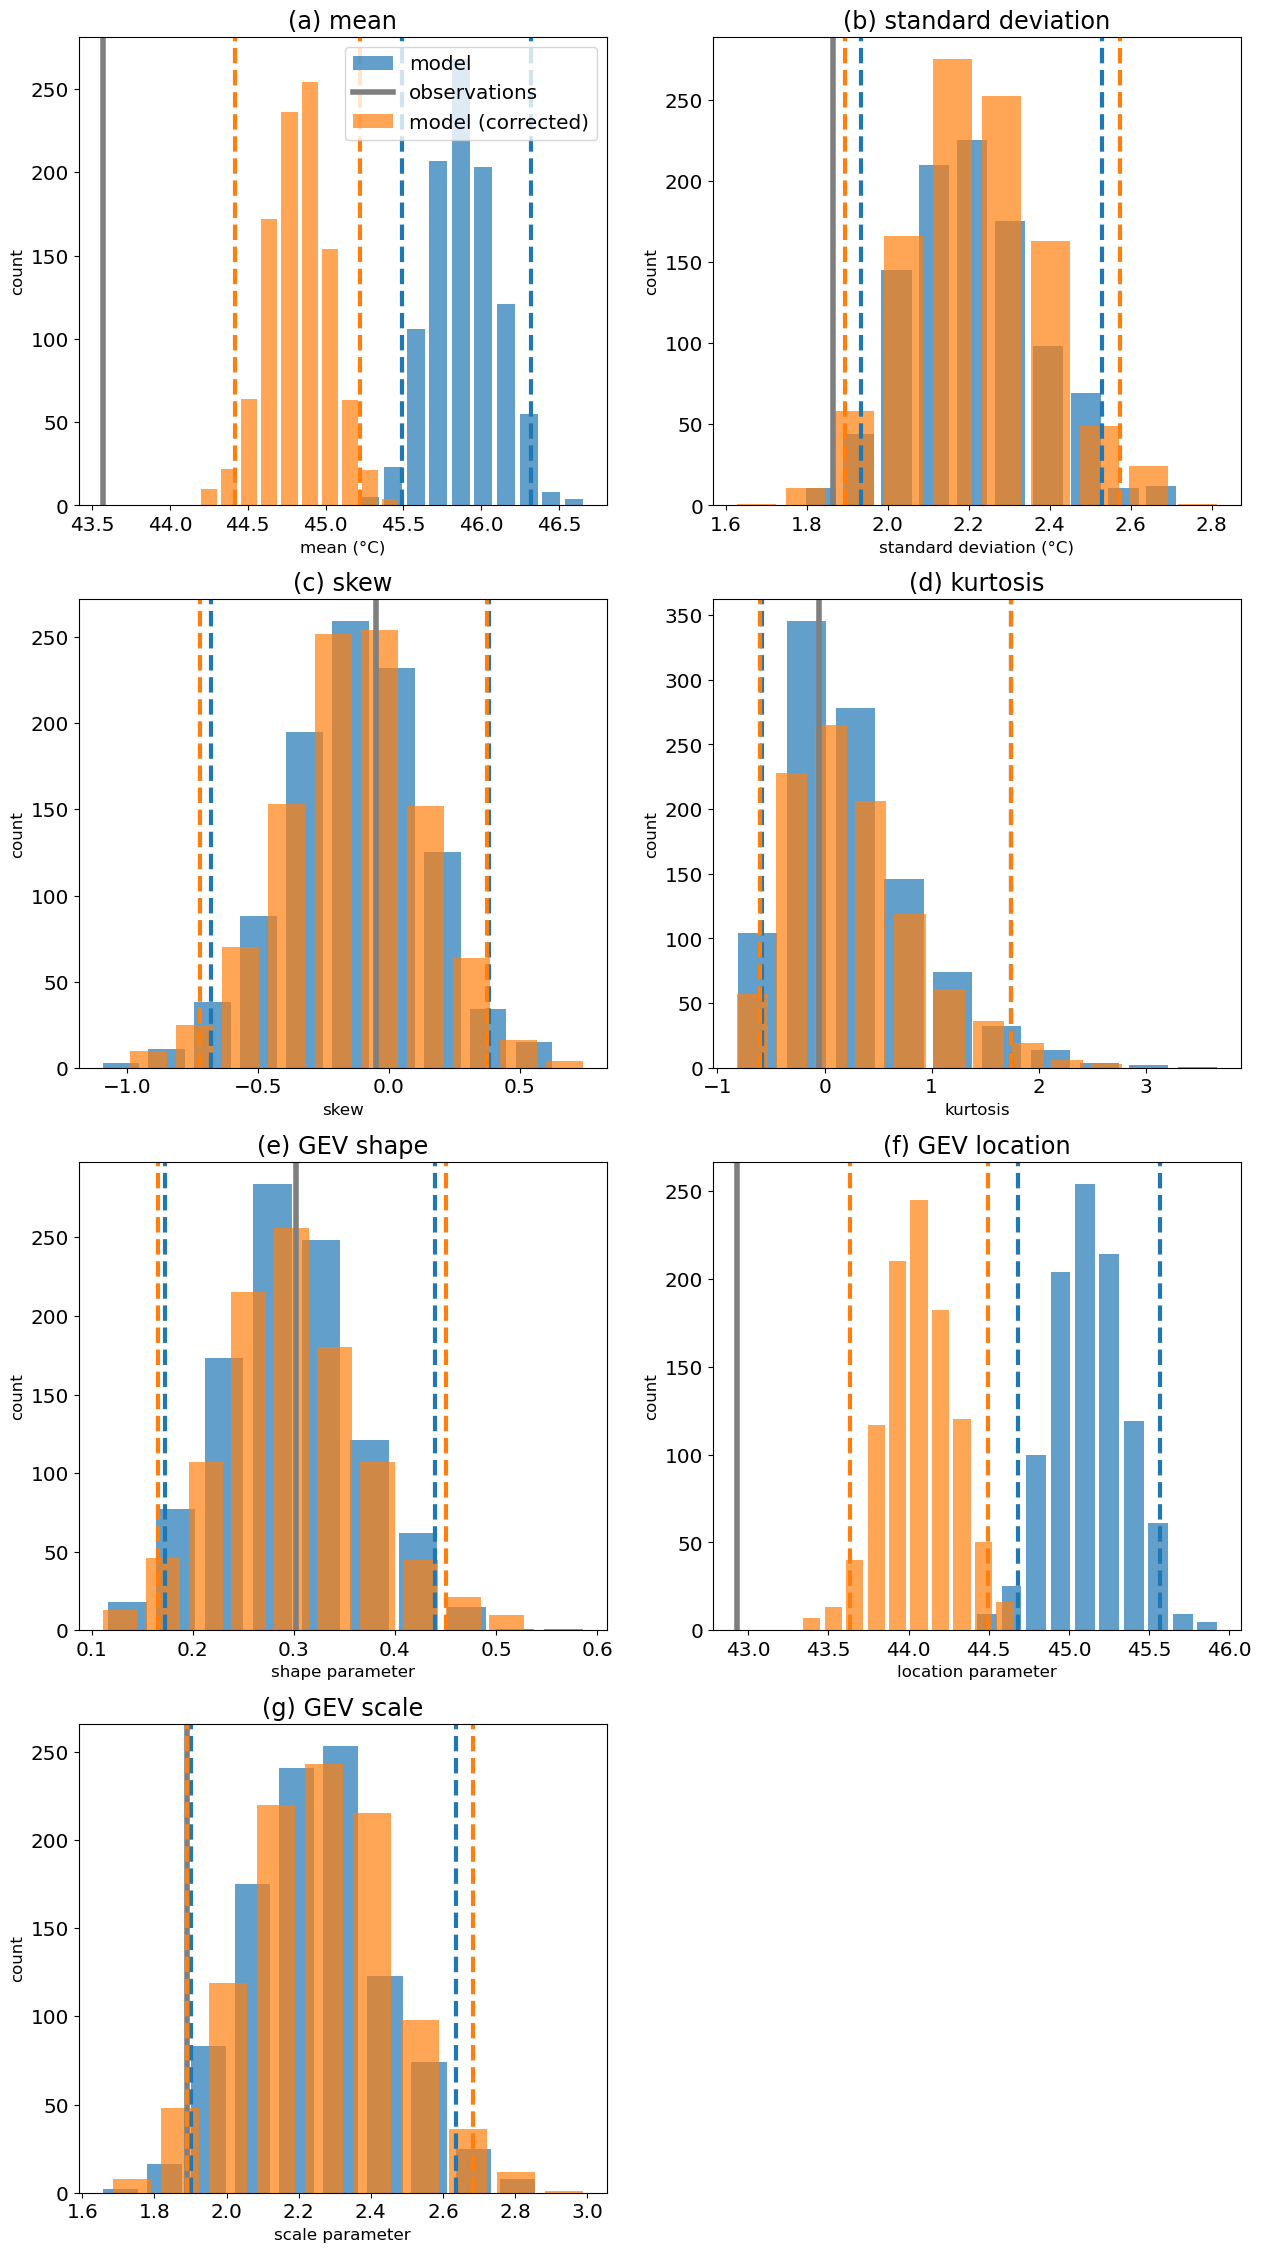

In [31]:
moments.create_plot(
    da_model,
    da_obs,
    da_bc_fcst=da_model_bc_mean_mulc,
)